In [1]:
import gurobipy as gp
from gurobipy import GRB
import  numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Markdown
import pickle
import matplotlib.pyplot as plt

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
with open("data/travel_time.pkl", "rb") as file:
    travel_time = pickle.load(file)
D = np.zeros((26,26,26))
c_matrix= travel_time.copy()
for i in range(26):
    for j in range(26):
        for k in range(26):
            D[i,j,k] = min(c_matrix[i][k]+c_matrix[k][i],c_matrix[j][k]+c_matrix[k][j],c_matrix[j][k]+c_matrix[k][i]-c_matrix[j][i],c_matrix[i][k]+c_matrix[k][j]-c_matrix[i][j])
            if D[i,j,k]<0:
                D[i,j,k]=0

In [3]:
#dfbase = pd.read_pickle('base.pkl')
#dfbaset = pd.read_pickle('base_4time.pkl')#update
#dfbasetherd = pd.read_pickle('vars_basecase_time_herd.pkl')
#dfod = pd.read_pickle('base_od.pkl')
#dfodt = pd.read_pickle('base_od_4time.pkl')#update
#dfherd = pd.read_pickle('base_4time_empweighted_500lambda.pkl')
#dfrand = pd.read_pickle('vars_basecase_od_time_herd_case60100.pkl')
dfrand = pd.read_pickle('results/actual_od_4time_emp_10lambda_odweighted.pkl')
#16876659.42004843

districts = {0: 'Antelope Valley', 
             1: 'East Valley', 
             2: 'Glendale', 
             3: 'San Fernando', 
             4: 'West Valley',
             5: 'Alhambra', 
             6: 'El Monte', 
             7: 'Foothill', 
             8: 'Pasadena', 
             9: 'Pomona',
             10: 'Central', 
             11: 'Hollywood-Wilshire', 
             12: 'Northeast', 
             13: 'West',
             14: 'Compton', 
             15: 'South', 
             16: 'Southeast', 
             17: 'Southwest',
             18: 'Bellflower', 
             19: 'East Los Angeles', 
             20: 'San Antonio', 
             21: 'Whittier',
             22: 'Harbor', 
             23: 'Inglewood', 
             24: 'Long Beach', 
             25: 'Torrance'}


In [4]:
#dfxbase = dfbase[dfbase.name=='x']
#dfybase = dfbase[dfbase.name=='y']
#dfzbase = dfbase[dfbase.name=='z']
#dfxbaset = dfbaset[dfbaset.name=='x']
#dfybaset = dfbaset[dfbaset.name=='y']
#dfzbaset = dfbaset[dfbaset.name=='z']
#dfxbasetherd = dfbasetherd[dfbasetherd.name=='x']
#dfybasetherd = dfbasetherd[dfbasetherd.name=='y']
#dfzbasetherd = dfbasetherd[dfbasetherd.name=='z']
#dfxod = dfod[dfod.name=='x']
#dfyod = dfod[dfod.name=='y']
#dfzod = dfod[dfod.name=='z']
#dfxodt = dfodt[dfodt.name=='x']
#dfyodt = dfodt[dfodt.name=='y']
#dfzodt = dfodt[dfodt.name=='z']
#dfxherd = dfherd[dfherd.name=='x']
#dfyherd = dfherd[dfherd.name=='y']
#dfzherd = dfherd[dfherd.name=='z']
dfxrand = dfrand[dfrand.name=='x']
dfyrand = dfrand[dfrand.name=='y']
dfzrand = dfrand[dfrand.name=='z']

In [5]:
total_pop = [420697,443569,344450,526877,899111,339399,419797,308499,140361,547523,354750,479505,287613,666399,278815,193899,166374,379199,356465,195082,407864,321720,201739,411617,469439,465691]


In [6]:
#print('lambda = 500')
#print(Herd500_herd)
#print('lambda = 10000')
#print(Herd10000_herd)
#print('diff')
#print(Herd10000_herd-Herd500_herd)
emp=[0.9785489423063246,
0.9749523393023726,
0.9810134958440276,
0.9715990029226316,
0.9512510687291531,
0.9793683522808072,
0.9739319327227332,
0.9817156078851325,
0.9915252477779021,
0.9678482424468472,
0.9760508448195166,
0.9657752125951641,
0.9784091897580796,
0.967984322913777,
0.9795198849727248,
0.9859672856449567,
0.9874863827092342,
0.9723956829474802,
0.9745472149882571,
0.985468457303294,
0.9697058020586842,
0.9771345654416476,
0.9898114604005365,
0.979337971566636,
0.9766137484373549,
0.9772144560727959]

In [7]:
HL = np.array(emp)*np.array(total_pop)

In [8]:
score = 0
groupedz = dfzrand.groupby(['i', 'j','k'])
resultsz = groupedz.sum()
groupedy = dfyrand.groupby(['i', 'j'])
resultsy = groupedy.sum()
for i in range(26):
    for j in range(26):
        score += resultsy['value'][(i,j)]*(2*travel_time[i][j])
        for k in range(26):     
            score += resultsz['value'][(i,j,k)]*D[i][j][k]
print(score)
ics = score.copy()

288885159.1600001


# Base model + OD + 6 periods + 60% herd imunity

In [9]:
'''
flow_matrix = np.zeros((26,26,6))
flow_matrix_od = np.zeros((26,26,26,6))
for t in range(6):
    for i in range(26):
        for j in range(26):
            new = dfyrand[dfyrand['i']==i]
            new = new[new['j']==j]
            new = new[new['t']==t]
            flow_matrix[i,j,t] = sum(new.value)
            for k in range(26):
                new2 = dfzrand[dfzrand['i']==i]
                new2 = new2[new2['j']==j]
                new2 = new2[new2['k']==k]
                new2 = new2[new2['t']==t]
                flow_matrix_od[i,j,k,t] = sum(new2.value)
'''
flow_matrix = np.zeros((26,26,6))
flow_matrix_od = np.zeros((26,26,26,6))
groupedz = dfzrand.groupby(['t','i', 'j','k'])
resultsz = groupedz.sum()
groupedy = dfyrand.groupby(['t','i', 'j'])
resultsy = groupedy.sum()
for t in range(6):
    for i in range(26):
        for j in range(26):
            flow_matrix[i,j,t] = resultsy['value'][(t,i,j)]
            for k in range(26):     
                flow_matrix_od[i,j,k,t] = resultsz['value'][(t,i,j,k)]
sites = list(dfxrand[dfxrand.value==1].i)

indices = np.arange(len(districts))
index_names = [districts[i] for i in indices]
categories = []
values = np.zeros((5,6))
sites_map = {}
count = 0
for site in sites:
    print(districts[site])
    sites_map[site]=count
    count+=1
    categories.append(districts[site])
    #print(np.sum(flow_matrix[:,site,:])+np.sum(flow_matrix_od[:,:,site,:]))
    #values.append(np.sum(flow_matrix[:,site,:])+np.sum(flow_matrix_od[:,:,site,:]))
print('more smooth')

San Fernando
Central
Northeast
Southwest
San Antonio
Inglewood
more smooth


In [10]:
flow_matrix1 = np.zeros((26,26,6))
flow_matrix_od1 = np.zeros((26,26,26,6))
groupedz = dfzrand.groupby(['t','i', 'j','k'])
resultsz = groupedz.sum()
groupedy = dfyrand.groupby(['t','i', 'j'])
resultsy = groupedy.sum()
for t in range(6):
    for i in range(26):
        for j in range(26):
            flow_matrix1[i,j,t] = resultsy['value'][(t,i,j)]
            for k in range(26):     
                flow_matrix_od1[i,j,k,t] = resultsz['value'][(t,i,j,k)]



In [11]:
np.sum(flow_matrix_od1-flow_matrix_od)

0.0

In [12]:
#print(np.where(flow_matrix[0]>0)[0][0])
first = 0
second = 0
third = 0
fourth = 0
fifth = 0
for site in list(districts.keys()):
    candiates = travel_time[site,:].copy()
    for vac_site in sites:
        candiates[vac_site] -= 1000
    sorted_indices = np.argsort(candiates)
    index1 = sorted_indices[0]
    index2 = sorted_indices[1]
    index3 = sorted_indices[2]
    index4 = sorted_indices[4]
    index5 = sorted_indices[5]
    percentage = 100*np.sum(flow_matrix[site,index1,:])/np.sum(flow_matrix[site])
    values[0,sites_map[index1]] += np.sum(flow_matrix[site,index1,:])
    values[1,sites_map[index2]] += np.sum(flow_matrix[site,index2,:])
    values[2,sites_map[index3]] += np.sum(flow_matrix[site,index3,:])
    values[3,sites_map[index4]] += np.sum(flow_matrix[site,index4,:])
    values[4,sites_map[index5]] += np.sum(flow_matrix[site,index5,:])
    percentage2 = 100*np.sum(flow_matrix[site,index2,:])/np.sum(flow_matrix[site])
    percentage3 = 100*np.sum(flow_matrix[site,index3,:])/np.sum(flow_matrix[site])
    first += np.sum(flow_matrix[site,index1,:])
    second += np.sum(flow_matrix[site,index2,:])
    third += np.sum(flow_matrix[site,index3,:])
    fourth += np.sum(flow_matrix[site,index4,:])
    fifth += np.sum(flow_matrix[site,index5,:])
    if percentage>100:
        print(districts[site])
        print(site)
        #print('preferred',districts[np.argmin(travel_time[site,:])])
        #print('actual',districts[np.where(flow_matrix[site]>0)[0][0]])
        print(percentage,'% go to closest vaccination site')
        print(percentage2,'% go to second closest vaccination site')
        print(percentage3,'% go to third closest vaccination site')


In [13]:
with open("data/travel_time.pkl", "rb") as file:
    c_m_v = pickle.load(file)

In [14]:
first_od = 0
second_od = 0
third_od = 0
fourth_od = 0
fifth_od = 0
first_odo = 0
second_odo = 0
third_odo = 0
fourth_odo = 0
fifth_odo = 0
first_odd = 0
second_odd = 0
third_odd = 0
fourth_odd = 0
fifth_odd = 0
for site in list(districts.keys()):
    for site2 in list(districts.keys()):
        candiates2 = D[site,site2,:].copy()
        candiates2[site] = -1
        for vac_site in sites:
            candiates2[vac_site] -= 1000
        sorted_indices = np.argsort(candiates2)
        index1 = sorted_indices[0]
        index2 = sorted_indices[1]
        index3 = sorted_indices[2]
        index4 = sorted_indices[3]
        index5 = sorted_indices[4]
        if np.sum(flow_matrix_od[site,site2])>0:
            percentage_route = 100*(np.sum(flow_matrix_od[site,site2,index1]))/np.sum(flow_matrix_od[site,site2])
        else:
            percentage_route = 100
        if np.sum(flow_matrix_od[site,site2])>0:
            percentage_route2 = 100*(np.sum(flow_matrix_od[site,site2,index2]))/np.sum(flow_matrix_od[site,site2])
        else:
            percentage_route2 = 100
        if np.sum(flow_matrix_od[site,site2])>0:
            percentage_route3 = 100*(np.sum(flow_matrix_od[site,site2,index3]))/np.sum(flow_matrix_od[site,site2])
        else:
            percentage_route3 = 100  
        if np.sum(flow_matrix_od[site,site2])>0:
            percentage_route4 = 100*(np.sum(flow_matrix_od[site,site2,index4]))/np.sum(flow_matrix_od[site,site2])
        else:
            percentage_route4 = 100 
        if np.sum(flow_matrix_od[site,site2])>0:
            percentage_route5 = 100*(np.sum(flow_matrix_od[site,site2,index5]))/np.sum(flow_matrix_od[site,site2])
        else:
            percentage_route5 = 100 
        first_od += np.sum(flow_matrix_od[site,site2,index1])
        if c_m_v[site,index1]<c_m_v[site2,index1]:
            first_odo += np.sum(flow_matrix_od[site,site2,index1])
        else:
            first_odd += np.sum(flow_matrix_od[site,site2,index1])
        if index2 == site2:
            values[0,sites_map[index1]] += np.sum(flow_matrix_od[site,site2,index1])
            values[0,sites_map[index2]] += np.sum(flow_matrix_od[site,site2,index2])
            values[1,sites_map[index3]] += np.sum(flow_matrix_od[site,site2,index3])
            values[2,sites_map[index4]] += np.sum(flow_matrix_od[site,site2,index4])
            values[3,sites_map[index5]] += np.sum(flow_matrix_od[site,site2,index5])
            first_od += np.sum(flow_matrix_od[site,site2,index2])
            if c_m_v[site,index2]<c_m_v[site2,index2]:
                first_odo += np.sum(flow_matrix_od[site,site2,index2])
            else:
                first_odd += np.sum(flow_matrix_od[site,site2,index2])
            second_od += np.sum(flow_matrix_od[site,site2,index3])
            if c_m_v[site,index2]<c_m_v[site2,index3]:
                second_odo += np.sum(flow_matrix_od[site,site2,index3])
            else:
                second_odd += np.sum(flow_matrix_od[site,site2,index3])
            third_od += np.sum(flow_matrix_od[site,site2,index4])
            if c_m_v[site,index3]<c_m_v[site2,index4]:
                third_odo += np.sum(flow_matrix_od[site,site2,index4])
            else:
                third_odd += np.sum(flow_matrix_od[site,site2,index4])
            fourth_od += np.sum(flow_matrix_od[site,site2,index5])
            if c_m_v[site,index4]<c_m_v[site2,index5]:
                fourth_odo += np.sum(flow_matrix_od[site,site2,index5])
            else:
                fourth_odd += np.sum(flow_matrix_od[site,site2,index5])
        else:
            values[0,sites_map[index1]] += np.sum(flow_matrix_od[site,site2,index1])
            values[1,sites_map[index2]] += np.sum(flow_matrix_od[site,site2,index2])
            values[2,sites_map[index3]] += np.sum(flow_matrix_od[site,site2,index3])
            values[3,sites_map[index4]] += np.sum(flow_matrix_od[site,site2,index4])
            values[4,sites_map[index5]] += np.sum(flow_matrix_od[site,site2,index5])
            second_od += np.sum(flow_matrix_od[site,site2,index2])
            if c_m_v[site,index2]<c_m_v[site2,index2]:
                second_odo += np.sum(flow_matrix_od[site,site2,index2])
            else:
                second_odd += np.sum(flow_matrix_od[site,site2,index2])
            third_od += np.sum(flow_matrix_od[site,site2,index3])
            if c_m_v[site,index3]<c_m_v[site2,index3]:
                third_odo += np.sum(flow_matrix_od[site,site2,index3])
            else:
                third_odd += np.sum(flow_matrix_od[site,site2,index3])
            fourth_od += np.sum(flow_matrix_od[site,site2,index4])
            if c_m_v[site,index4]<c_m_v[site2,index4]:
                fourth_odo += np.sum(flow_matrix_od[site,site2,index4])
            else:
                fourth_odd += np.sum(flow_matrix_od[site,site2,index4])
            fifth_od += np.sum(flow_matrix_od[site,site2,index5])
            if c_m_v[site,index5]<c_m_v[site2,index5]:
                fifth_odo += np.sum(flow_matrix_od[site,site2,index5])
            else:
                fifth_odd += np.sum(flow_matrix_od[site,site2,index5])
        if percentage_route>100:
            print('OD pair '+districts[site]+' to '+districts[site2])
            if percentage_route>0:
                print(percentage_route,'% go to closest vaccination site')
            if percentage_route2>0:
                print(percentage_route2,'% go to second closest vaccination site')
            if percentage_route3>0:
                print(percentage_route3,'% go to third closest vaccination site')
            if percentage_route4>0:
                print(percentage_route4,'% go to fourth closest vaccination site')
            if percentage_route5>0:
                print(percentage_route5,'% go to fourth closest vaccination site')

In [15]:
#print('Overall,\n\n for non-communters,\n',100*first/np.sum(flow_matrix),'% people go to closest vaccine site;\n',100*second/np.sum(flow_matrix),'% people go to second closest vaccine site;\n',100*third/np.sum(flow_matrix),'% people go to third closest vaccine site;\n')
#print('for communters,\n',100*first_od/np.sum(flow_matrix_od),'% people go to closest vaccine site;\n',100*second_od/np.sum(flow_matrix_od),'% people go to second closest vaccine site;\n',100*third_od/np.sum(flow_matrix_od),'% people go to third closest vaccine site;\n',100*fifth_od/np.sum(flow_matrix_od),'% people go to fifth closest vaccine site;\n')
print(100*(first+first_odo)/sum(total_pop),'% people go to closest vaccine site;')
print(100*(first_odd)/sum(total_pop),'% people go to closest (D) vaccine site;\n')
print(100*(second+second_odo)/sum(total_pop),'% people go to 2nd closest vaccine site;')
print(100*(second_odd)/sum(total_pop),'% people go to 2nd closest (D) vaccine site;\n')
print(100*(third+third_odo)/sum(total_pop),'% people go to 3rd closest vaccine site;')
print(100*(third_odd)/sum(total_pop),'% people go to 3rd closest (D) vaccine site;\n')
print(100*(fourth+fourth_odo)/sum(total_pop),'% people go to 4th closest vaccine site;')
print(100*(fourth_odd)/sum(total_pop),'% people go to 4th closest (D) vaccine site;\n')
print(100*(fifth+fifth_odo)/sum(total_pop),'% people go to 5th closest vaccine site;')
print(100*(fifth_odd)/sum(total_pop),'% people go to 5th closest (D) vaccine site;\n')
(first+first_odo+first_odd)/sum(total_pop)

68.85130076894583 % people go to closest vaccine site;
19.08921140016201 % people go to closest (D) vaccine site;

6.711864433826754 % people go to 2nd closest vaccine site;
3.2535729979911143 % people go to 2nd closest (D) vaccine site;

1.2468814996807445 % people go to 3rd closest vaccine site;
0.6881096746666369 % people go to 3rd closest (D) vaccine site;

0.06572612810072236 % people go to 4th closest vaccine site;
0.07754486281989624 % people go to 4th closest (D) vaccine site;

0.0 % people go to 5th closest vaccine site;
0.015788233806288843 % people go to 5th closest (D) vaccine site;



0.8794051216910784

In [16]:
sum(values[1])/np.sum(values)

0.0996543743181787

In [17]:
plt.figure(figsize=(8, 6), dpi=1200)  # Set figure size and DPI for high resolution


plt.bar(categories, values[0], color='navajowhite')
plt.bar(categories, values[1], bottom=values[0], color='yellowgreen')
plt.bar(categories, values[2], bottom=values[1]+values[0], color='thistle')


plt.xlabel('Mega Sites',fontsize=18)
plt.ylabel('Number of Vaccinations',fontsize=18)
#plt.title('Bar Plot Example')

plt.xticks(rotation=45,fontsize=16)  # Rotate the x-axis labels if needed
plt.yticks(fontsize=16)
plt.tight_layout()  # Adjust layout to prevent label clipping
plt.ylim(-1, 3000000)
plt.legend(['closest', '2nd closest', '3rd closest'])
plt.savefig('bar_plot.pdf', dpi=1200, bbox_inches='tight')  # Save as a high-resolution image


In [18]:
196,572,213

(196, 572, 213)

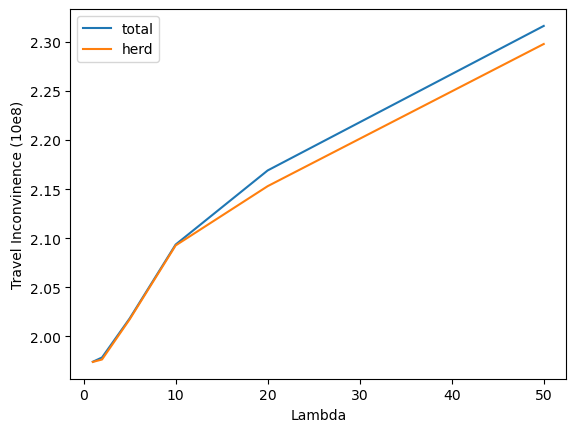

In [19]:
lambda_ = np.array([1,2,5,10,20,50])
total_travel = np.array([197406863,197842052,201815975,209351232,216904035,231634306])
total_score = np.array([17451035,17500705,16948488,16352128,16523677,15900059])
total_infection = np.array([402476,402612,403176,405431,405323,405119])
herd_travel = np.array([197389518,197637565,201724792,209260624,215302070,229792389])
herd_score = np.array([17302595,17257957,16666657,16257549,16209549,15547756])
herd_infection = np.array([401215,402393,403206,405582,405384,405169])
import matplotlib.pyplot as plt


plt.plot(lambda_, total_travel/100000000,label='total')
plt.plot(lambda_, herd_travel/100000000,label='herd')
plt.xlabel("Lambda")
plt.ylabel("Travel Inconvinence (10e8)")
plt.legend()
plt.show()

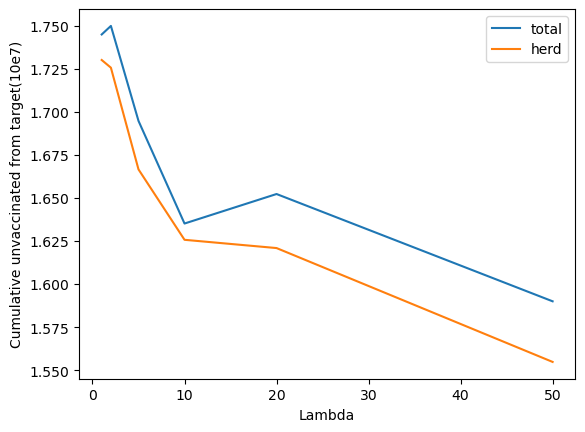

In [20]:
plt.plot(lambda_, total_score/10000000,label='total')
plt.plot(lambda_, herd_score/10000000,label='herd')
plt.xlabel("Lambda")
plt.ylabel("Cumulative unvaccinated from target(10e7)")
plt.legend()
plt.show()

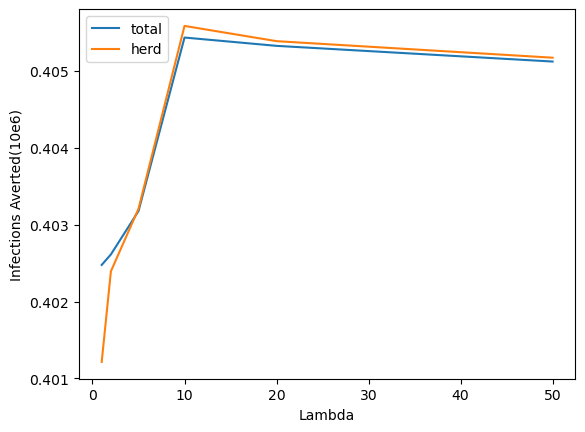

In [21]:
plt.plot(lambda_, total_infection/1000000,label='total')
plt.plot(lambda_, herd_infection/1000000,label='herd')
plt.xlabel("Lambda")
plt.ylabel("Infections Averted(10e6)")
plt.legend()
plt.show()

In [22]:
((2.85-2.24)*10**8)/sum(total_pop)

6.083905636030444

In [23]:
((2.85-2.24)*(10**8))

60999999.999999985

In [24]:
target = emp*np.array(total_pop)
target

array([411672.60438144, 432458.63419201, 337910.09864348, 511913.16786287,
       855280.29965614, 332396.63939575, 408853.70356121, 302858.28331696,
       139171.47530335, 529919.17324923, 346254.03719972, 463094.04331544,
       281403.20229389, 645063.78480542, 273104.83672867, 191178.07071927,
       164292.05943687, 368731.470578  , 347391.97299079, 192247.15758764,
       395508.08725086, 314363.73239389, 199683.57420974, 403112.15784234,
       458460.58145268, 455079.977263  ])

In [25]:
groupedz = dfzrand.groupby(['t', 'i'])
resultsz = groupedz.sum()
groupedy = dfyrand.groupby(['t', 'i'])
resultsy = groupedy.sum()


In [26]:
score = 0
help_ = np.zeros(26)
for t in range(6):
    for i in range(26):
        help_[i] += (resultsz['value'][(t,i)]+resultsy['value'][(t,i)])
        score += max(0,target[i]-help_[i])
print(score)
print(ics)

15908482.674384417
288885159.1600001


In [27]:
89127941/sum(total_pop)

8.889278402912934

In [28]:
c_m_v.shape

(26, 26)

In [29]:
vac_rate = np.zeros((6,26))
for t in range(6):
    for hd in range(26):
        if t == 0:
            vac_rate[t,hd]= resultsy['value'][(t,hd)]+resultsz['value'][(t,hd)]
        else:
            vac_rate[t,hd]= vac_rate[t-1,hd]+resultsy['value'][(t,hd)]+resultsz['value'][(t,hd)]
for t in range(6):
    for hd in range(26):
        vac_rate[t,hd] = vac_rate[t,hd]/total_pop[hd]

In [30]:
vac_rate

array([[0.21941445, 0.20810066, 0.26798665, 0.17519839, 0.10266586,
        0.27197193, 0.21988723, 0.29921653, 0.65764707, 0.16859383,
        0.26020296, 0.19250686, 0.32094864, 0.13850711, 0.33108333,
        0.47606228, 0.55485833, 0.24342627, 0.25895389, 0.47314975,
        0.22632054, 0.28693274, 0.45753176, 0.22424973, 0.19663471,
        0.19822371],
       [0.55434196, 0.52575811, 0.40404123, 0.44262892, 0.15478845,
        0.68712342, 0.55553994, 0.75595059, 0.99152899, 0.42594558,
        0.65739253, 0.29024098, 0.48388633, 0.34995101, 0.49915535,
        0.71775512, 0.83648286, 0.36701574, 0.65422412, 0.98547278,
        0.34121178, 0.72488188, 0.68986165, 0.33811043, 0.49678446,
        0.29885053],
       [0.97854988, 0.96383426, 0.53982   , 0.97160058, 0.15778808,
        0.97936941, 0.97393264, 0.98171793, 0.99152899, 0.96784975,
        0.97605356, 0.29024098, 0.48388633, 0.96798465, 0.49915535,
        0.71775512, 0.83648286, 0.36701574, 0.97454729, 0.98547278,
      

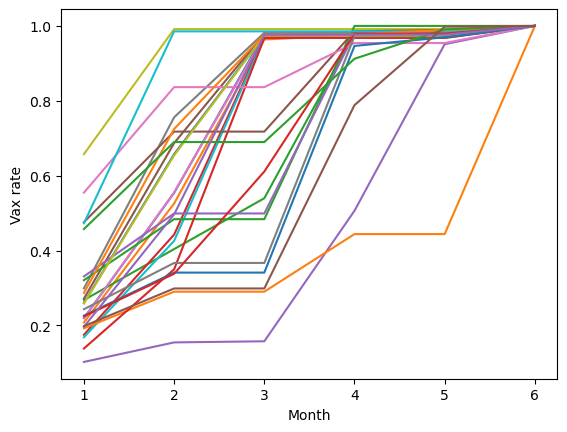

In [31]:
month = [1,2,3,4,5,6]
for hd in range(26):
    plt.plot(month, vac_rate[:,hd],label=districts[hd])
plt.xlabel("Month")
plt.ylabel("Vax rate")
#plt.legend()
plt.show()

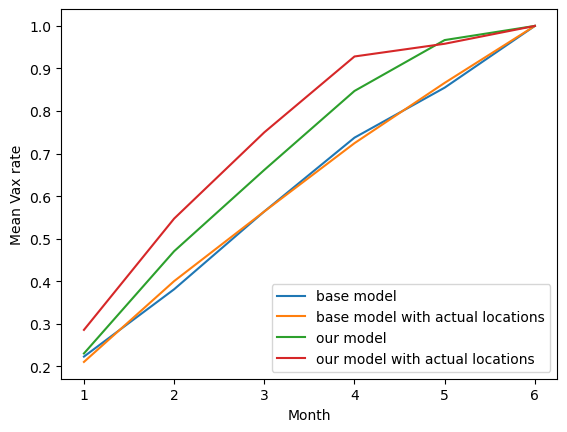

In [32]:
month = [1,2,3,4,5,6]
models =['results/base_od_4time.pkl','results/base_od_4time_real.pkl','results/base_od_4time_emp_10lambda_odweighted.pkl','results/actual_od_4time_emp_10lambda_odweighted.pkl']
names = ['base model','base model with actual locations','our model','our model with actual locations']
for (model,name) in zip(models,names):
    dfrand = pd.read_pickle(model)
    dfxrand = dfrand[dfrand.name=='x']
    dfyrand = dfrand[dfrand.name=='y']
    dfzrand = dfrand[dfrand.name=='z']
    groupedz = dfzrand.groupby(['t', 'i'])
    resultsz = groupedz.sum()
    groupedy = dfyrand.groupby(['t', 'i'])
    resultsy = groupedy.sum()
    vac_rate = np.zeros((6,26))
    mean_vac_rate = np.zeros(6)
    for t in range(6):
        for hd in range(26):
            if t == 0:
                vac_rate[t,hd]= resultsy['value'][(t,hd)]+resultsz['value'][(t,hd)]
            else:
                vac_rate[t,hd]= vac_rate[t-1,hd]+resultsy['value'][(t,hd)]+resultsz['value'][(t,hd)]
    for t in range(6):
        for hd in range(26):
            vac_rate[t,hd] = vac_rate[t,hd]/total_pop[hd]
        mean_vac_rate[t] = np.mean(vac_rate[t])
    plt.plot(month, mean_vac_rate,label=name)
plt.xlabel("Month")
plt.ylabel("Mean Vax rate")
plt.legend()
plt.show()

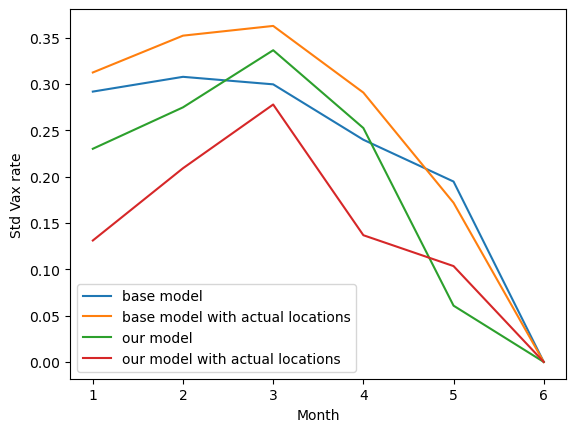

In [33]:
month = [1,2,3,4,5,6]
models =['results/base_od_4time.pkl','results/base_od_4time_real.pkl','results/base_od_4time_emp_10lambda_odweighted.pkl','results/actual_od_4time_emp_10lambda_odweighted.pkl']
names = ['base model','base model with actual locations','our model','our model with actual locations']
for (model,name) in zip(models,names):
    dfrand = pd.read_pickle(model)
    dfxrand = dfrand[dfrand.name=='x']
    dfyrand = dfrand[dfrand.name=='y']
    dfzrand = dfrand[dfrand.name=='z']
    groupedz = dfzrand.groupby(['t', 'i'])
    resultsz = groupedz.sum()
    groupedy = dfyrand.groupby(['t', 'i'])
    resultsy = groupedy.sum()
    vac_rate = np.zeros((6,26))
    mean_vac_rate = np.zeros(6)
    for t in range(6):
        for hd in range(26):
            if t == 0:
                vac_rate[t,hd]= resultsy['value'][(t,hd)]+resultsz['value'][(t,hd)]
            else:
                vac_rate[t,hd]= vac_rate[t-1,hd]+resultsy['value'][(t,hd)]+resultsz['value'][(t,hd)]
    for t in range(6):
        for hd in range(26):
            vac_rate[t,hd] = vac_rate[t,hd]/total_pop[hd]
        mean_vac_rate[t] = np.std(vac_rate[t])
    plt.plot(month, mean_vac_rate,label=name)
plt.xlabel("Month")
plt.ylabel("Std Vax rate")
plt.legend()
plt.show()